# Hyperparameter search in non-sequential pipelines

This notebook shows how hyperparameter search for pyWATTS Pipelines can be performed. We show this on two different pipelines.

The first pipeline performs a simple load forecast. The seond pipeline performs an electricity price forecast based on an historical load forecast.


In [1]:
import pandas as pd
from pywatts.callbacks import LinePlotCallback
from pywatts.modules import CalendarExtraction, CalendarFeature, SKLearnWrapper
from pywatts.modules.preprocessing.select import Select
from pywatts.summaries import RMSE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from examples.load_data import load_elec_data
from pywatts_pipeline.core.pipeline import Pipeline
from pywatts_pipeline.core.util.computation_mode import ComputationMode
import warnings
warnings.filterwarnings('ignore')

To apply hyperparameter optimization, the parameter and the search space needs to be defined. For the GridCV hyperparameter search, we can use the sklearn interface, which is a dict that maps from a key to the possible parameter values, whereby each key is a parameter of the pipeline. Note that the double underscore `__` is a separator and indicates nesting. E.g., `calendar__features` is the key to the parameter features of the pipeline module called calendar.

## Hyperparameter search for Non-Sequential Electricity Price Forecasting Pipeline

The second pipeline combines the power of pyWATTS to model non-sequential pipelines with the GridSearch from sklearn. Thus, we define the following non-sequential pipeline that predicts the electricity price of the next day based on calendar information, historical information, and a 48 hour load forecast.


In this notebook, we consider the following simple forecasting scenario. We aim to forecast the day-ahead electricity price. Since the electricity price is dependent on the electrical demand, we create a pipeline that forecasts the electricity demand and uses this forecast as an input for the electricity price forecast. As additional information, we use calendar features.
So we use the following transformers in this pipeline and search for the best hyperparameter:
* CalendarExtraction
  * List of features
* Scaler for the Electricity price
* Scaler for the Electricity demand
* Forecaster for the Electricity price
* Forecaster for the Electricity demand


In [2]:
# Create a pipeline
pipeline = Pipeline(path="../results")

# Extract dummy calendar features, using holidays from Germany
# NOTE: CalendarExtraction can't return multiple features.
calendar = CalendarExtraction(continent="Europe",
                              country="Germany",
                              features=[CalendarFeature.month,CalendarFeature.weekday,
                                        CalendarFeature.weekend],
                              name="calendar"
                              )(x=pipeline["load_power_statistics"])

calendar_load = Select(start=0, stop=24, step=1)(x=calendar)
calendar_price = Select(start=0, stop=48, step=1)(x=calendar)

# Scale the data using a standard SKLearn scaler
power_scaler = SKLearnWrapper(module=StandardScaler(), name="scaler_power")
scale_power = power_scaler(x=pipeline["load_power_statistics"])

price_scaler = SKLearnWrapper(module=StandardScaler(), name="scaler_price")
scale_price = price_scaler(x=pipeline["price_day_ahead"])

# Create lagged time series to later be used as regressors
lag_features_load = Select(start=-24, stop=0, step=1, name="lag_features_load")(x=scale_power)
lag_features_price = Select(start=-24, stop=0, step=1, name="lag_features_price")(x=scale_price)

target_load = Select(start=0, stop=48, step=1, name="load_hist")(x=scale_power)
target_price = Select(start=0, stop=24, step=1, name="price_hist")(x=scale_price)

target_price_unscaled = Select(start=0, stop=24, step=1, name="target")(x=pipeline["price_day_ahead"])

# Create a linear regression that uses the lagged values to predict the current value
# NOTE: SKLearnWrapper has to collect all **kwargs itself and fit it against target.
#       It is also possible to implement a join/collect class
forecast_load = SKLearnWrapper(module=LinearRegression(fit_intercept=True), name="load_forecast")(
    features=lag_features_load,
    calendar=calendar_load,
    target=target_load,
)

forecast_price_scaled = SKLearnWrapper(module=LinearRegression(fit_intercept=True), name="price_forecast")(
    features=lag_features_price,
    calendar=calendar_price,
    load=forecast_load,
    target=target_price,
)

# Rescale the predictions to be on the original time scale
forecast_price = price_scaler(
    x=forecast_price_scaled, computation_mode=ComputationMode.Transform,
    method="inverse_transform", callbacks=[LinePlotCallback("rescale")]
)

# Calculate the root mean squared error (RMSE) between the linear regression and the true values
# save it as csv file
rmse = RMSE(name="rmse")(y_hat=forecast_price, y=target_price_unscaled)

pipeline.set_score("rmse", direction="lower")

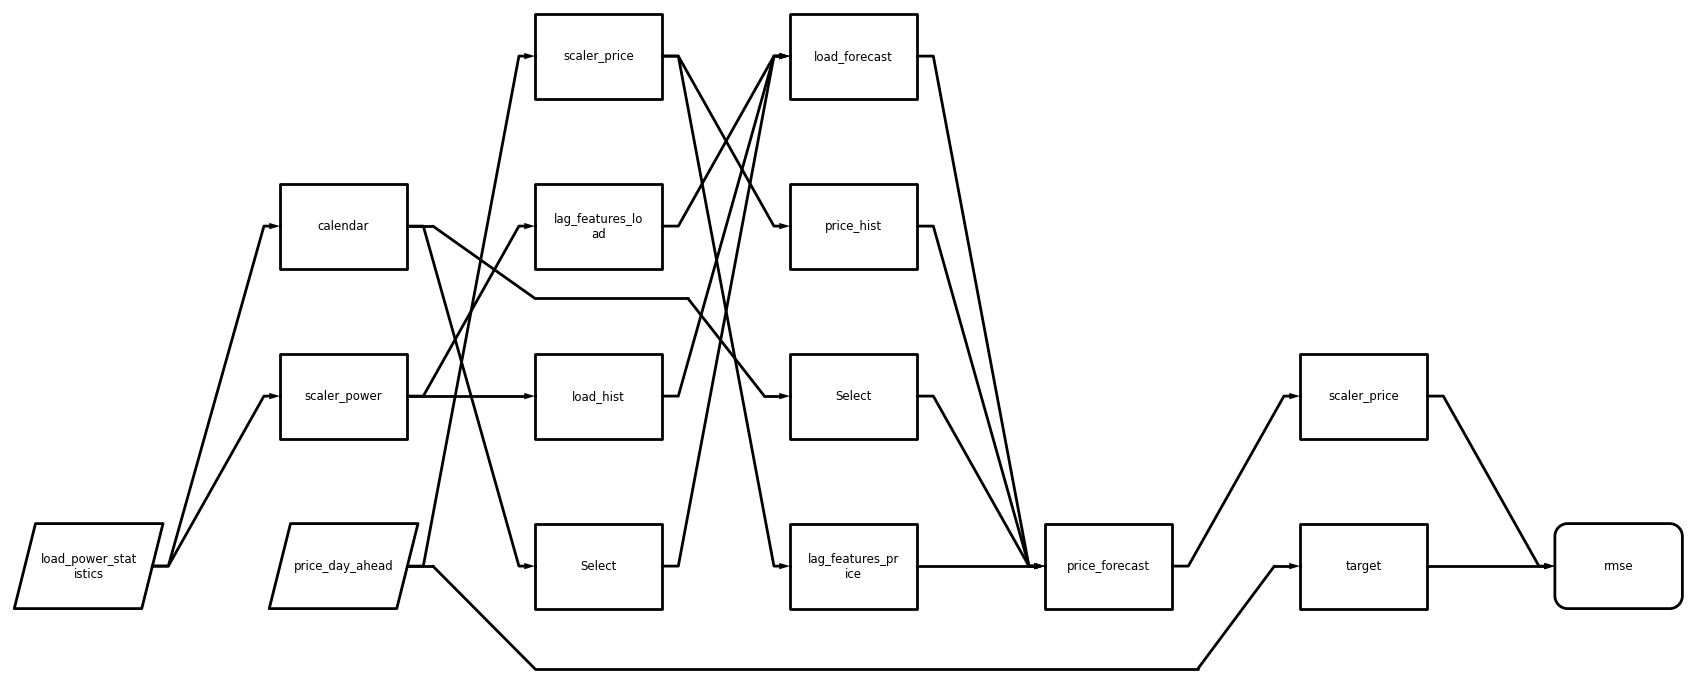

In [3]:
drawing = pipeline.draw()
drawing.draw()

To apply hyperparameter optimization, the parameter and the search space needs to be defined. For the GridCV hyperparameter search, we can use the sklearn interface, which is a dict that maps from a key to the possible parameter values, whereby each key is a parameter of the pipeline. Note that the double underscore `__` is a separator and indicates nesting. E.g., `calendar__features` is the key to the parameter features of the pipeline module called calendar.


In [4]:
data = load_elec_data()

train_data = data[:6000]
test_data = data[6000:]

params = {
    "load_forecast__module": [LinearRegression(), MLPRegressor()],
    "price_forecast__module": [LinearRegression(), MLPRegressor()],
    "scaler_power__module": [MinMaxScaler(), StandardScaler()],
    "scaler_price__module": [MinMaxScaler(), StandardScaler()],
    "calendar__features": [[CalendarFeature.month_cos, CalendarFeature.month_sine, CalendarFeature.weekend],
                           [CalendarFeature.hour_cos, CalendarFeature.hour_sine, CalendarFeature.weekend]],
}

In [5]:
pipeline.get_params(deep=True)

{'steps': [[1,
   'calendar',
   {'x': 'load_power_statistics'},
   {'callbacks': [],
    'condition': None,
    'computation_mode': <ComputationMode.Default: 4>,
    'refit_conditions': [],
    'lag': Timedelta('0 days 00:00:00'),
    'method': None}],
  [2,
   'Select',
   {'x': 'calendar'},
   {'callbacks': [],
    'condition': None,
    'computation_mode': <ComputationMode.Default: 4>,
    'refit_conditions': [],
    'lag': Timedelta('0 days 00:00:00'),
    'method': None}],
  [3,
   'Select_1',
   {'x': 'calendar'},
   {'callbacks': [],
    'condition': None,
    'computation_mode': <ComputationMode.Default: 4>,
    'refit_conditions': [],
    'lag': Timedelta('0 days 00:00:00'),
    'method': None}],
  [4,
   'scaler_power',
   {'x': 'load_power_statistics'},
   {'callbacks': [],
    'condition': None,
    'computation_mode': <ComputationMode.Default: 4>,
    'refit_conditions': [],
    'lag': Timedelta('0 days 00:00:00'),
    'method': None}],
  [5,
   'scaler_price',
   {'x': '

In [6]:
result, summary = pipeline.train(data=train_data)

#pipeline.test(data=test)
pipeline.score(test_data)


-12.726233709498345

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(test_size=168*4)
pipeline_cv = GridSearchCV(pipeline, param_grid=params, cv=tscv)
pipeline_cv.fit(data)

In [ ]:
pipeline_cv.best_params_

In [ ]:
pd.DataFrame(pipeline_cv.cv_results_)